In [1]:
import numpy as np
import pandas as pd
import random
from itertools import combinations
from itertools import permutations
import math

# Sources:

- https://en.wikipedia.org/wiki/Mersenne_Twister
- https://github.com/yinengy/Mersenne-Twister-in-Python/blob/master/RandomClass.py
- https://canvas.hu.nl/courses/27428/assignments/168825


#  PRNG (Mersenne Twister):

In [34]:
class MT():
    
    def __init__(self, i_seed):
    
        self.w = 32
        self.r = 31
        self.n = 624
        self.m = 397
        self.u = 11
        self.s = 7
        self.t = 15
        self.l = 18
        self.a = 0x9908b0df
        self.b = 0x9d2c5680
        self.c = 0xefc60000
        self.f = 0x6c078965
        self.upper_mask = 0x80000000
        self.lower_mask = 0x7FFFFFFF
        
        self.x = [1 for i in range(self.n)]
        
        self.init_array(i_seed)
        
    def init_array(self,seed):
        
            self.x[0] = seed

            self.index = self.n

            for i in range(1, self.n):

                self.x[i] = self.f * (self.x[i-1] ^ (self.x[i-1] >> (self.w-2))) + i & 0xffffffff
        
        
    def generate_numbers(self):
        for i in range(self.n):
            y = (self.x[i] & self.upper_mask) + (self.x[(i+1) % self.n] & self.lower_mask)
            
            # shiftright by default
            xA = y >> 1

            # shiftright AND bitwise exclusive OR if y % 2 == 1
            if (y % 2) == 1:
                xA = xA ^ self.a
            
            self.x[i] = self.x[(i + self.m) % self.n] ^ xA
            
        self.index = 0
        
        
    def tempering(self):
        
       
        if self.index >= self.n:
            self.generate_numbers()
        
        y = self.x[self.index]
        y = y ^ (y >> self.u)
        y = y ^ ((y << self.s) & self.b)
        y = y ^ ((y << self.t) & self.c)
        y = y ^ (y >> self.l)
        
        self.index += 1
                
        return y
    
    def random(self):
        # convert to number with domain [0,1>
        
        return self.tempering() / 2**self.w
    
    
    def randint(self, a, b):
        # generate random int within domain [a,b> 
        
        return int(self.random()/(1/(b-a)) + a)
     

In [35]:
# initialize mt object with seed 5489
mt = MT(5489)


# these results match with the results in the Canvas example
[mt.tempering() for _ in range(10)]


[3499211612,
 581869302,
 3890346734,
 3586334585,
 545404204,
 4161255391,
 3922919429,
 949333985,
 2715962298,
 1323567403]

# Testing the randomness of the MT class:

<AxesSubplot:ylabel='Frequency'>

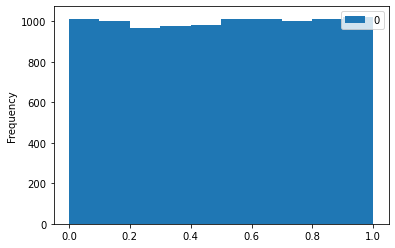

In [36]:
pd.DataFrame([mt.random() for _ in range(10000)]).plot.hist()

In [16]:
from PIL import Image

img = Image.new('1', (200, 200))
pixels = img.load()
for x in range(img.size[0]):
    for y in range(img.size[1]):
        randomNumber = mt.random() # TODO: replace with RNG call
        pixels[x, y] = 0 if randomNumber < 0.5 else 1

img.show()

# Simulating Football Games:

In [6]:

indices = ['Ajax','Feyenoord','PSV','FC Utrecht','Willem II']
data = {'Ajax':[None,'30/21/49','39/22/39','25/14/61','17/18/65'],
       'Feyenoord':['65/17/18', None, '54/22/24', '37/23/40','20/26/54'],
       'PSV':['54/21/25', '37/24/39', None, '29/24/47', '23/24/53'],
       'FC Utrecht':['74/14/12', '51/22/27', '62/20/18', None, '37/25/38'],
       'Willem II':['78/13/9', '60/21/19', '62/22/16', '52/23/25', None]}
df = pd.DataFrame(data)
df = df.set_index(pd.Series(indices))
df

,Ajax,Feyenoord,PSV,FC Utrecht,Willem II
Ajax,None,65/17/18,54/21/25,74/14/12,78/13/9
Feyenoord,30/21/49,None,37/24/39,51/22/27,60/21/19
PSV,39/22/39,54/22/24,None,62/20/18,62/22/16
FC Utrecht,25/14/61,37/23/40,29/24/47,None,52/23/25
Willem II,17/18/65,20/26/54,23/24/53,37/25/38,None


In [7]:
def roll(data):
    
    rand = mt.randint(1,100)
    
    data = data.split('/')
    
    
    win_rec = int(data[0])
    tie_rec = int(data[1])
    loss_rec = int(data[2])
    
    
    if rand <= win_rec:
        return 3
    elif win_rec + tie_rec >= rand > win_rec:
        return 1
    elif rand > win_rec + tie_rec:
        return 0
        

def sim():
    
    
    # create a list of all possible games
    games = list(permutations(indices, 2))
    
    point_df = pd.DataFrame({'points':np.zeros(5)}).set_index(pd.Series(indices))
    
    for x in games:
        result = roll(df.loc[x[0]][x[1]])
        
        
        point_df.points[x[0]] += result

        
        if result == 1:
            point_df.points[x[1]] += 1

            
        elif result == 0:
            point_df.points[x[1]] += 3
            
    return point_df.sort_values(by = 'points', ascending = False)

sim()

,points
Ajax,17.0
PSV,11.0
Willem II,10.0
FC Utrecht,9.0
Feyenoord,7.0


In [8]:
def sim_multiple(iterations):
    
    mc_frame = pd.DataFrame({k:np.zeros(len(indices)) for k in range(1,len(indices)+1)}).set_index(pd.Series(indices))

    for _ in range(iterations):
        sim_result = sim()
        
        for i in range(len(list(sim_result.index))):
            mc_frame.loc[list(sim_result.index)[i]][i+1] += 1
            
    return mc_frame/iterations

In [9]:
mc_df = sim_multiple(5000)

In [37]:
th_props = [
    ('font-size', '11px'),
    ('text-align', 'center'),
    ('font-weight', 'bold'),
    ('color', '#6d6d6d'),
    ('background-color', '#f7f7f9')
  ]

td_props = [
    ('font-size', '11px'),
    ('color', '11px')

  ]

styles = [
    dict(selector="th", props=th_props),
    dict(selector="td", props=td_props)
  ]

In [38]:
import seaborn as sns

cm = sns.color_palette("flare", as_cmap=True)

(mc_df.style
  .background_gradient(cmap=cm)
  .set_caption('Percentage of times a club placed at a specific position in our simulations')
  .set_table_styles(styles))

,1,2,3,4,5
Ajax,0.623000,0.237600,0.097200,0.034500,0.007700
Feyenoord,0.110300,0.263200,0.319400,0.213100,0.094000
PSV,0.228500,0.359000,0.253100,0.123500,0.035900
FC Utrecht,0.030100,0.102500,0.218400,0.381000,0.268000
Willem II,0.008100,0.037700,0.111900,0.247900,0.594400


In [13]:
goal_df = pd.DataFrame({'HS':[3.2,2.4,2.1,1.9,1.4], 'HC':[0.9,1.1,0.7,1.2,1.7], 'AS':[3.1,2.2,1.8,3,1],'AC':[0.6,0.8,1.3,2.4,1.5]}).set_index(pd.Series(indices))

goal_df


,HS,HC,AS,AC
Ajax,3.2,0.9,3.1,0.6
Feyenoord,2.4,1.1,2.2,0.8
PSV,2.1,0.7,1.8,1.3
FC Utrecht,1.9,1.2,3.0,2.4
Willem II,1.4,1.7,1.0,1.5
